#**Using CNN on MNIST Data**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, datasets
import matplotlib.pyplot as plt

In [ ]:
class CNNModel:
    def __init__(self):
        self.model = self.build_model()

    def build_model(self):
        model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.Flatten(),

        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),   # Adding dropout with a dropout rate of 0.5
        layers.Dense(10, activation='softmax')
        ])
        return model


    def compile_model(self):
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
        self.model.compile(optimizer=optimizer,
                       loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])

    def train_model(self, train_images, train_labels, epochs=5, batch_size=64, validation_split=0.1):
        history = self.model.fit(train_images, train_labels, epochs=epochs, batch_size=batch_size, validation_split=validation_split)
        return history

    def evaluate_model(self, test_images, test_labels):
        test_loss, test_acc = self.model.evaluate(test_images, test_labels)
        print('Test accuracy:', test_acc)
        return test_loss, test_acc

    def plot_history(self, history):
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()



11490434/11490434 [==============================] - 0s 0us/step
Epoch 1/5
844/844 [==============================] - 11s 7ms/step - loss: 0.2102 - accuracy: 0.9360 - val_loss: 0.0420 - val_accuracy: 0.9870
Epoch 2/5
844/844 [==============================] - 5s 6ms/step - loss: 0.0681 - accuracy: 0.9807 - val_loss: 0.0315 - val_accuracy: 0.9915
Epoch 3/5
844/844 [==============================] - 5s 6ms/step - loss: 0.0475 - accuracy: 0.9864 - val_loss: 0.0343 - val_accuracy: 0.9913
Epoch 4/5
844/844 [==============================] - 5s 6ms/step - loss: 0.0369 - accuracy: 0.9890 - val_loss: 0.0324 - val_accuracy: 0.9923
Epoch 5/5
313/313 [==============================] - 1s 3ms/step - loss: 0.0205 - accuracy: 0.9936
Test accuracy: 0.9936000108718872


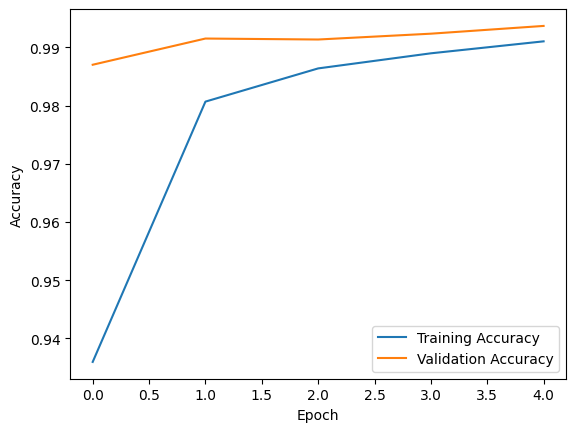

In [ ]:
def main():
    # Load and preprocess the MNIST dataset
    (train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()
    train_images = train_images.reshape((train_images.shape[0], 28, 28, 1)).astype('float32') / 255.0
    test_images = test_images.reshape((test_images.shape[0], 28, 28, 1)).astype('float32') / 255.0

    # Create an instance of CNNModel
    cnn_model = CNNModel()

    # Compile the model
    cnn_model.compile_model()

    # Train the model
    history = cnn_model.train_model(train_images, train_labels)

    # Evaluate the model
    test_loss, test_acc = cnn_model.evaluate_model(test_images, test_labels)

    # Plot training and validation accuracy
    cnn_model.plot_history(history)

if __name__ == "__main__":
    main()


#**Using Transformers on MNIST Data**

In [ ]:
import numpy as np
import tensorflow as tf

In [ ]:
# this is written as a tensorflow "layer".  it's just a vector the same size as the
# output of the previous layer. the vector is initialized randomly, but we'll use
# gradient descent to update the values in the vector
#
# it's purpose is to be appended to the beginning of the sequence of vectors fed into
# the transformer.  then after the transformer runs on the whole data, we just grab
# the resulting zero-th vector...the class token...and use that as the portfolio weights
class ClassToken(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()

    def build(self, input_shape):
        w_init = tf.random_normal_initializer()
        self.w = tf.Variable(
            initial_value = w_init(shape=(1, 1, input_shape[-1]), dtype=tf.float32),
            trainable = True
        )

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        hidden_dim = self.w.shape[-1]

        cls = tf.broadcast_to(self.w, [batch_size, 1, hidden_dim])
        cls = tf.cast(cls, dtype=inputs.dtype)
        return cls

In [ ]:
def build_ViT(n,m,block_size,hidden_dim,num_layers,num_heads,key_dim,mlp_dim,dropout_rate,num_classes):
    # n is number of rows of blocks
    # m is number of cols of blocks
    # block_size is number of pixels (with rgb) in each block

    inp = tf.keras.layers.Input(shape=(n*m,block_size))
    inp2 = tf.keras.layers.Input(shape=(n*m))
    mid = tf.keras.layers.Dense(hidden_dim)(inp) # transform to vectors with different dimension
    # the positional embeddings
#     positions = tf.range(start=0, limit=n*m, delta=1)
    emb = tf.keras.layers.Embedding(input_dim=n*m, output_dim=hidden_dim)(inp2) # learned positional embedding for each of the n*m possible possitions
    mid = mid + emb # for some reason, tf.keras.layers.Add causes an error, but + doesn't?
    # create and append class token to beginning of all input vectors
    token = ClassToken()(mid) # append class token to beginning of sequence
    mid = tf.keras.layers.Concatenate(axis=1)([token, mid])

    for l in range(num_layers): # how many Transformer Head layers are there?
        ln  = tf.keras.layers.LayerNormalization()(mid) # normalize
        mha = tf.keras.layers.MultiHeadAttention(num_heads=num_heads,key_dim=key_dim,value_dim=key_dim)(ln,ln,ln) # self attention!
        add = tf.keras.layers.Add()([mid,mha]) # add and norm
        ln  = tf.keras.layers.LayerNormalization()(add)
        den = tf.keras.layers.Dense(mlp_dim,activation='gelu')(ln) # maybe should be relu...who knows...
        den = tf.keras.layers.Dropout(dropout_rate)(den) # regularization
        den = tf.keras.layers.Dense(hidden_dim)(den) # back to the right dimensional space
        den = tf.keras.layers.Dropout(dropout_rate)(den)
        mid = tf.keras.layers.Add()([den,add]) # add and norm again
    ln = tf.keras.layers.LayerNormalization()(mid)
    fl = ln[:,0,:] # just grab the class token for each image in batch
    clas = tf.keras.layers.Dense(num_classes,activation='softmax')(fl) # probability that the image is in each category
    mod = tf.keras.models.Model([inp,inp2],clas)
    mod.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    return mod

In [ ]:
n = 7
m = 7
block_size = 16
hidden_dim = 96
num_layers = 6
num_heads = 4
key_dim = hidden_dim//num_heads # usually good practice for key_dim to be hidden_dim//num_heads...this is why we do Multi-Head attention
mlp_dim = hidden_dim
dropout_rate = 0
num_classes = 10



trans = build_ViT(n,m,block_size,hidden_dim,num_layers,num_heads,key_dim,mlp_dim,dropout_rate,num_classes)
trans.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 49, 16)]             0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 49)]                 0         []                            
                                                                                                  
 dense (Dense)               (None, 49, 96)               1632      ['input_1[0][0]']             
                                                                                                  
 embedding (Embedding)       (None, 49, 96)               4704      ['input_2[0][0]']             
                                                                                              

In [ ]:
mnist = tf.keras.datasets.mnist

(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

ndata_train = x_train.shape[0]
ndata_test = x_test.shape[0]

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
x_train.shape

(60000, 28, 28)

In [ ]:
x_train_ravel = np.zeros((ndata_train,n*m,block_size))
for img in range(ndata_train):
    ind = 0
    for row in range(n):
        for col in range(m):
            x_train_ravel[img,ind,:] = x_train[img,(row*4):((row+1)*4),(col*4):((col+1)*4)].ravel()
            ind += 1


In [ ]:
x_test_ravel = np.zeros((ndata_test,n*m,block_size))
for img in range(ndata_test):
    ind = 0
    for row in range(n):
        for col in range(m):
            x_test_ravel[img,ind,:] = x_test[img,(row*4):((row+1)*4),(col*4):((col+1)*4)].ravel()
            ind += 1

In [ ]:
pos_feed_train = np.array([list(range(n*m))]*ndata_train)
pos_feed_test = np.array([list(range(n*m))]*ndata_test)

In [ ]:
trans.fit([x_train_ravel,pos_feed_train],y_train,epochs=50,batch_size = 40,validation_split=0.20)

Epoch 1/50
1200/1200 [==============================] - 40s 21ms/step - loss: 0.5805 - accuracy: 0.8023 - val_loss: 0.3174 - val_accuracy: 0.9004
Epoch 2/50
1200/1200 [==============================] - 26s 22ms/step - loss: 0.2233 - accuracy: 0.9284 - val_loss: 0.1921 - val_accuracy: 0.9399
Epoch 3/50
1200/1200 [==============================] - 24s 20ms/step - loss: 0.1662 - accuracy: 0.9478 - val_loss: 0.1237 - val_accuracy: 0.9620
Epoch 4/50
1200/1200 [==============================] - 26s 22ms/step - loss: 0.1353 - accuracy: 0.9566 - val_loss: 0.1521 - val_accuracy: 0.9505
Epoch 5/50
1200/1200 [==============================] - 25s 21ms/step - loss: 0.1184 - accuracy: 0.9621 - val_loss: 0.0987 - val_accuracy: 0.9688
Epoch 6/50
1200/1200 [==============================] - 24s 20ms/step - loss: 0.0993 - accuracy: 0.9681 - val_loss: 0.0927 - val_accuracy: 0.9709
Epoch 7/50
1200/1200 [==============================] - 25s 21ms/step - loss: 0.0883 - accuracy: 0.9720 - val_loss: 0.1012 -

In [ ]:
out = trans.evaluate([x_test_ravel,pos_feed_test],y_test)

313/313 [==============================] - 6s 17ms/step - loss: 0.0632 - accuracy: 0.9841


In [ ]:
n = 7
m = 7
block_size = 16
hidden_dim = 64
num_layers = 6
num_heads = 6
key_dim = hidden_dim//num_heads # usually good practice for key_dim to be hidden_dim//num_heads...this is why we do Multi-Head attention
mlp_dim = hidden_dim
dropout_rate = 0.10
num_classes = 10



trans = build_ViT(n,m,block_size,hidden_dim,num_layers,num_heads,key_dim,mlp_dim,dropout_rate,num_classes)
trans.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 49, 16)]             0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, 49)]                 0         []                            
                                                                                                  
 dense_28 (Dense)            (None, 49, 64)               1088      ['input_5[0][0]']             
                                                                                                  
 embedding_2 (Embedding)     (None, 49, 64)               3136      ['input_6[0][0]']             
                                                                                            

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

# Train the model
trans.fit([x_train_ravel, pos_feed_train], y_train, epochs=100, batch_size=40, validation_split=0.20,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/100
1200/1200 [==============================] - 332s 268ms/step - loss: 0.6503 - accuracy: 0.7814 - val_loss: 0.2484 - val_accuracy: 0.9276


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/100
1200/1200 [==============================] - 331s 276ms/step - loss: 0.2735 - accuracy: 0.9142 - val_loss: 0.1772 - val_accuracy: 0.9477
Epoch 3/100
1200/1200 [==============================] - 337s 281ms/step - loss: 0.2042 - accuracy: 0.9360 - val_loss: 0.2016 - val_accuracy: 0.9377
Epoch 4/100
1200/1200 [==============================] - 340s 283ms/step - loss: 0.1659 - accuracy: 0.9486 - val_loss: 0.1371 - val_accuracy: 0.9589
Epoch 5/100
1200/1200 [==============================] - 336s 280ms/step - loss: 0.1431 - accuracy: 0.9553 - val_loss: 0.1306 - val_accuracy: 0.9615
Epoch 6/100
1200/1200 [==============================] - 338s 281ms/step - loss: 0.1297 - accuracy: 0.9593 - val_loss: 0.1229 - val_accuracy: 0.9627
Epoch 7/100
1200/1200 [==============================] - 323s 269ms/step - loss: 0.1186 - accuracy: 0.9626 - val_loss: 0.1086 - val_accuracy: 0.9679
Epoch 8/100
1200/1200 [==============================] - 337s 281ms/step - loss: 0.1099 - accuracy: 0.9651

In [ ]:
out = trans.evaluate([x_test_ravel,pos_feed_test],y_test)

NameError: name 'trans' is not defined